In [5]:
import sys
sys.path.append(".")

import cv2
import numpy as np
from IPython.display import Image, display
import matplotlib.pyplot as plt

from line_segmentation import compute_roi, line_segmentation

In [6]:
## Compute a lookahead point for the pure pursuit algorithm

In [7]:
PTS_IMAGE_PLANE = [[483, 210],
                   [244, 206],
                   [173, 249],
                   [584, 286]]

PTS_GROUND_PLANE = [[39, -13],
                    [39, 13],
                    [23, 13],
                    [23, -13]]

METERS_PER_INCH = 0.0254

def transformUvToXy(self, u, v):
    """
    u and v are pixel coordinates.
    The top left pixel is the origin, u axis increases to right, and v axis
    increases down.

    Returns a normal non-np 1x2 matrix of xy displacement vector from the
    camera to the point on the ground plane.
    Camera points along positive x axis and y axis increases to the left of
    the camera.

    Units are in meters.
    """
    homogeneous_point = np.array([[u], [v], [1]])
    xy = np.dot(self.h, homogeneous_point)
    scaling_factor = 1.0 / xy[2, 0]
    homogeneous_xy = xy * scaling_factor
    x = homogeneous_xy[0, 0]
    y = homogeneous_xy[1, 0]
    return x, y


[[320 158 574 202]]
[[320 160 613 211]]
[[303 260 357 329]]
[[216 149 302 255]]
[[238 188 267 238]]
[[264 235 322 336]]
[[217 149 249 209]]
[[226 162 306 261]]
[[558 201 643 216]]
[[279 264 316 330]]


Text(0.5, 1.0, 'Filtered Lines')

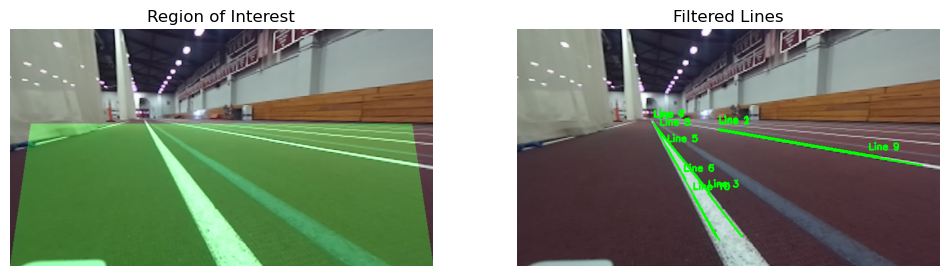

In [8]:
image = cv2.imread("racetrack_images/lane_1/image2.png")
if image is None:
    raise IOError("Could not read the image.")

lines = line_segmentation(image)

# Get ROI mask for debugging
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

lower_white = np.array([0, 0, 200])
upper_white = np.array([180, 50, 255])
mask = cv2.inRange(hsv, lower_white, upper_white)

roi_mask = compute_roi(mask)

# Display ROI overlaid on original image
roi_display = image.copy()
overlay = np.zeros_like(image)
overlay[roi_mask > 0] = [0, 255, 0]  # Green overlay
roi_display = cv2.addWeighted(roi_display, 1, overlay, 0.3, 0)
# End ROI mask

# Draw detected lines on image
line_image = image.copy()
if lines is not None:
    for i, line in enumerate(lines):
        print(line)
        x1, y1, x2, y2 = line[0]
        # Draw the line
        cv2.line(line_image, (x1,y1), (x2,y2), (0,255,0), 2)
        # Add text label
        cv2.putText(line_image, f"Line {i+1}", (x1, y1-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot ROI
ax1.imshow(cv2.cvtColor(roi_display, cv2.COLOR_BGR2RGB))
ax1.set_axis_off()
ax1.set_title('Region of Interest')

# Plot detected lines
ax2.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))
ax2.set_axis_off()
ax2.set_title('Filtered Lines')